<a href="https://colab.research.google.com/github/adasegroup/ML2020_seminars/blob/master/seminar10/Sequential_Solutions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Toy Sequential Bayesian Learning

Course: MA06018, Machine Learning by professor [Evgeny Burnaev](mailto:e.burnaev@skoltech.ru) 

Author: [Evgenii Egorov](mailto:egorov.evgenyy@ya.ru)

In [0]:
import numpy as np
from scipy.stats import multivariate_normal as mvn
from numpy.polynomial.polynomial import polyval
import matplotlib.pyplot as plt
%matplotlib inline

We consider the following model:
    
\begin{equation*}
    \begin{aligned}
    & p(t_n|x_n, w;\beta) = \mathcal{N}(t_n| \textbf{w}^Tx_n, \beta^{-1}), \\
    & p(\textbf{t}|X,\textbf{w};\beta) = \prod\limits_{n=1}^{N}p(t_n|x_n, \textbf{w};\beta) = \mathcal{N}(\textbf{t}|X\textbf{w}, \beta^{-1}), \\
    & p(\textbf{w};\alpha) = \prod\limits_{d=1}^{D}\mathcal{N}(w_d|0, \alpha_d^{-1})=\mathcal{N}(\textbf{w}|0,A^{-1}).
    \end{aligned}
\end{equation*}  

And for sequential updates we come up with the following equations:


- Observe $(X,\textbf{t})^{1}$ and obtain:

    $$\Sigma_{w}^{-1} = [\beta X_{(1)}^TX_{(1)} + A]$$
    $$\mu_{w} = \Sigma_{w}\beta X^T_{(1)}\textbf{t}_{(1)}$$
    
    
- Observe $(X,\textbf{t})^{2}$ and then for joint data:

    $$\Sigma_{w,(1,2)}^{-1} = [\beta X_{(2)}^T X_{(2)} + \Sigma_{w}^{-1}]$$
    
    $$\mu_{w,(1,2)} = \Sigma_{w,(1,2)}(\beta X_{(2)}^T\textbf{t}_{(2)}+\Sigma^{-1}_w\mu_w)$$

- $\dots$


For details and derivations please see the corresponding slides: [slides](https://drive.google.com/open?id=1ezz6LXef6pFdbljSvvZIlnmYqietQg-s)

##### Task 1.1
Please write code at the method <i>update_w</i>.

In [0]:
class BLR:
    def __init__(self, A, beta, x_dim=2):
        self.w_Pr = {'mu': np.zeros(x_dim), 'cov': np.linalg.inv(A), 'inv_cov': A}
        self.beta = beta
        
    def update_w(self, X, y, verbose=False):
        inv_cov = self.beta * X.T @ X + self.w_Pr['inv_cov']
        cov = np.linalg.inv(inv_cov)
        mu = cov @ (self.beta * X.T @ y[:,None] + self.w_Pr['inv_cov'] @ self.w_Pr['mu'][:,None])
        
        self.w_Pr = {'mu': mu.flatten(), 'cov': cov, 'inv_cov': inv_cov}
        return {'mu': mu.flatten(), 'cov': cov, 'inv_cov': inv_cov} if verbose else 0.0
    
    def plot_w_space(self, ax, b=15.):
        xx, yy = np.mgrid[-b:b:0.01, -b:b:0.01]
        grid = np.c_[xx.ravel(), yy.ravel()]
        probs = mvn.logpdf(grid, mean=self.w_Pr['mu'], cov=self.w_Pr['cov'])
        contour = ax.contourf(xx,yy,probs.reshape(xx.shape))
        
    def plot_poly_data_space(self, x, y, ax, k=2):
        k_points = np.linspace(-1.1, 1.1, num=k+1)
        for i in range(50):
            w = np.random.multivariate_normal(self.w_Pr['mu'], self.w_Pr['cov'])
            poly_values = np.zeros_like(k_points)
            poly_values = polyval(k_points, w)
            ax.plot(k_points, poly_values, 'r-', alpha=0.15)
        
        ax.scatter(x[:,:,1].flatten(), y.flatten(), edgecolor="white", alpha=0.75, color='blue')
        ax.scatter(x[-1,:,1].flatten(), y[-1].flatten(), edgecolor="white", alpha=1., color='green')
        
    def plot_data_space(self, x, y, ax):
        a, b = (-1.1, 1.1) 
        for i in range(50):
            w = np.random.multivariate_normal(self.w_Pr['mu'], self.w_Pr['cov'])
            ax.plot(np.array([a,b]), np.array([w[0]+w[1]*a, w[0]+w[1]*b]), 'r-', alpha=0.15)
        ax.scatter(x[:,:,1].flatten(), y.flatten(), edgecolor="white", alpha=0.75, color='blue')
        ax.scatter(x[-1,:,1].flatten(), y[-1].flatten(), edgecolor="white", alpha=1., color='green')

##### Task 1.2
Now we code test your code at simple linear example

In [0]:
x1 = np.linspace(-1, 1, 10)
np.random.shuffle(x1)
x1 = x1.reshape(5, 2)

y = 1.5 + 12. * x1
y += np.random.randn(*y.shape) * 2.5

x0 = np.ones_like(x1)
X = np.stack([x0, x1], axis=-1)

In [0]:
reg = BLR(np.diag([1.,1.]), 1.)

/home/evgenii.egorov/anaconda3/lib/python3.6/site-packages/matplotlib/text.py:1150: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


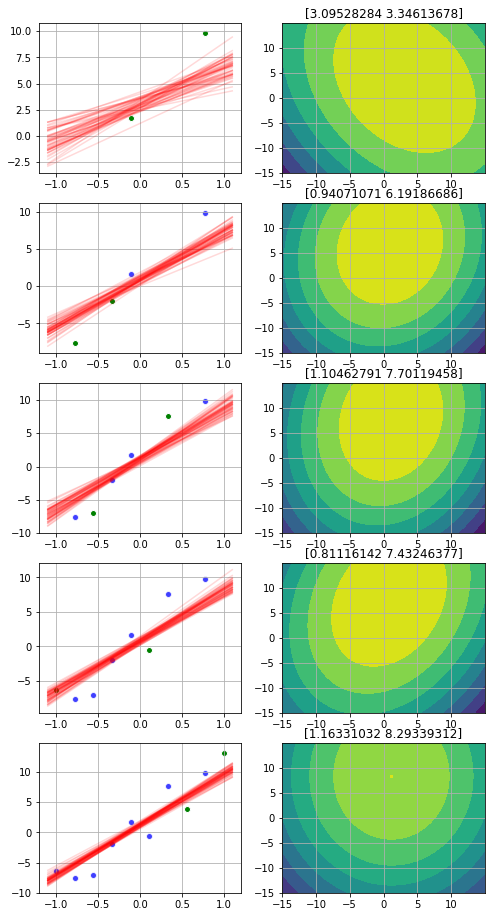

In [0]:
chunks = 5
fig, ax = plt.subplots(chunks,2, figsize=(8,16))
for i in range(chunks):
    reg.update_w(X[i], y[i])
    reg.plot_data_space(X[:i+1], y[:i+1], ax[i,0])
    reg.plot_w_space(ax[i,1])
    ax[i,1].set_title(reg.w_Pr['mu'])
for i in ax.flatten(): i.grid()

##### Task 1.3
Let's see how it will be going on at mode complex example

In [0]:
x1 = np.linspace(-1, 1, 100)
x1 = x1.reshape(10, 10)

y = np.sin(1/x1) * x1
y += np.random.randn(*y.shape) * 0.1

x0 = np.ones_like(x1)
x2 = x1 ** 2
x3 = x1 ** 3
x4 = x1 ** 4
X = np.stack([x0, x1, x2, x3, x4], axis=-1)

In [0]:
reg = BLR(np.diag([1.,1.,1.,1.,1]), 25., x_dim=5)

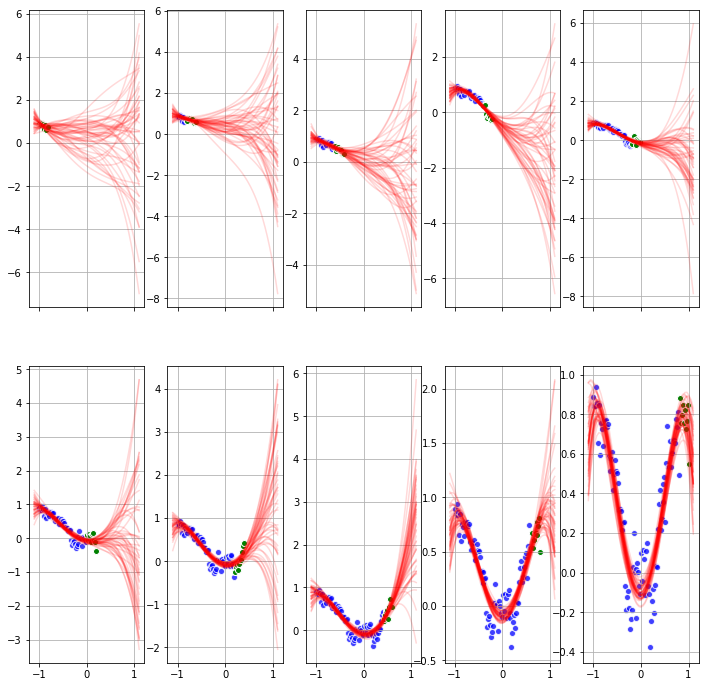

In [0]:
chunks = 10
fig, ax = plt.subplots(2, chunks//2, figsize=(12,12), sharex=True)

for i, a in enumerate(ax.flatten()):
    reg.update_w(X[i], y[i])
    reg.plot_poly_data_space(X[:i+1], y[:i+1], a, k=50)
for i in ax.flatten(): i.grid()